# In this notebook, we explore various models and their performance on the dataset

Jack Duryea (jd50), Shashank Mahesh (sm103)


In [41]:
import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from scipy import stats
import glob
import data_utils as du
import cv2
from collections import defaultdict
from skimage.color import rgb2gray
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Models Selection
We are currently thinking about using the following models:  
Otsu Thresholding   
Spectral clustering 

## Load data

In [3]:
train_image_data = du.get_train_images() 
train_mask_data  = du.get_train_masks()
test_image_data = du.get_test_images()

In [22]:
im1 = train_image_data[0]
m1 = train_mask_data[10]

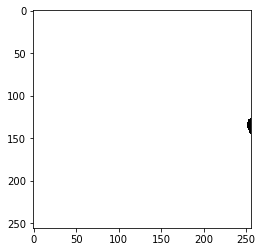

In [23]:
plt.imshow(m1.im,cmap='Greys')

In [24]:
m1.im.shape

(256, 256)

In [25]:
im1.im.shape

(256, 256, 4)

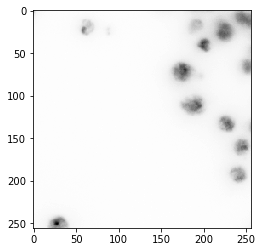

In [26]:
plt.imshow(rgb2gray(im1.im),cmap='Greys')

In [20]:
im1.dir_id

'stage1_train/5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856/'

In [21]:
m1.dir_id

'stage1_train/5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856/'

In [29]:
bw = rgb2gray(im1.im)

In [32]:
np.argwhere(bw > 0.1)

array([[  0,   0],
       [  0, 238],
       [  0, 239],
       ..., 
       [255,  35],
       [255,  36],
       [255,  37]])

In [34]:
bw2 = np.where(bw>0.1,1,0)

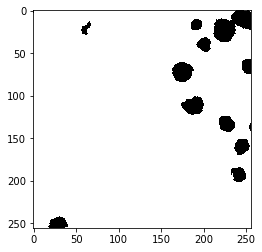

In [36]:
plt.imshow(bw2,cmap='Greys')

In [42]:
du.encode(bw2)

array([    1,     4,  4863,     1,  5115,     1,  5117,     4,  5368,
           9,  5623,    10,  5879,    10,  6134,    11,  6390,    11,
        6645,    12,  6901,    12,  7156,    13,  7412,    13,  7668,
          13,  7923,    14,  8179,    14,  8436,    13,  8692,    13,
        8948,    13,  9205,    12,  9461,    12,  9719,    10,  9976,
           8, 10234,     6, 10492,     4, 14359,     3, 14613,     7,
       14868,     9, 15124,     9, 15380,     9, 15635,    11, 15891,
          11, 16145,     7, 16155,     3, 16400,     7, 16412,     1,
       16655,     7, 16910,     8, 17168,     4, 41797,     4, 41802,
           2, 42052,    10, 42307,    12, 42562,    15, 42817,    18,
       43072,    20, 43327,    21, 43583,    21, 43838,    23, 44094,
          23, 44350,    23, 44606,    23, 44654,     4, 44862,    24,
       44909,     7, 45118,    24, 45165,     8, 45374,    23, 45421,
           9, 45631,    22, 45677,    10, 45887,    22, 45932,    12,
       46143,    21,

In [44]:
du.rle_to_string(du.encode(bw2))

'1 4 4863 1 5115 1 5117 4 5368 9 5623 10 5879 10 6134 11 6390 11 6645 12 6901 12 7156 13 7412 13 7668 13 7923 14 8179 14 8436 13 8692 13 8948 13 9205 12 9461 12 9719 10 9976 8 10234 6 10492 4 14359 3 14613 7 14868 9 15124 9 15380 9 15635 11 15891 11 16145 7 16155 3 16400 7 16412 1 16655 7 16910 8 17168 4 41797 4 41802 2 42052 10 42307 12 42562 15 42817 18 43072 20 43327 21 43583 21 43838 23 44094 23 44350 23 44606 23 44654 4 44862 24 44909 7 45118 24 45165 8 45374 23 45421 9 45631 22 45677 10 45887 22 45932 12 46143 21 46186 15 46400 19 46441 17 46656 19 46697 18 46913 17 46953 18 47170 15 47209 18 47380 2 47427 13 47465 18 47631 8 47683 11 47721 19 47886 11 47940 5 47976 20 48141 12 48198 3 48231 21 48396 13 48486 21 48652 13 48742 21 48908 12 48998 21 49164 12 49193 1 49255 20 49420 12 49447 6 49510 21 49676 12 49701 9 49767 20 49933 10 49956 10 50023 20 50189 10 50211 12 50279 19 50446 7 50466 14 50536 17 50703 5 50722 15 50792 17 50978 15 51051 10 51063 1 51234 15 51310 4 51489 17 